# Getting Data

## In this section i extract the data i get from app and arrange it as i can use

In [1]:
!pip install python-chess

import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 56.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=b1fa8a4ab7ad74fb3d9ddbaa74afa875103bbebfa74a4959d4461b0f7ee88a9e
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [2]:
print("I upload the files in format pgn")
uploaded = files.upload()

I upload the files in format pgn


Saving chess_com_games_2025-11-25 (1).pgn to chess_com_games_2025-11-25 (1).pgn
Saving chess_com_games_2025-11-25 (2).pgn to chess_com_games_2025-11-25 (2).pgn
Saving chess_com_games_2025-11-25 (3).pgn to chess_com_games_2025-11-25 (3).pgn
Saving chess_com_games_2025-11-25 (4).pgn to chess_com_games_2025-11-25 (4).pgn
Saving chess_com_games_2025-11-25 (5).pgn to chess_com_games_2025-11-25 (5).pgn
Saving chess_com_games_2025-11-25 (6).pgn to chess_com_games_2025-11-25 (6).pgn
Saving chess_com_games_2025-11-25 (7).pgn to chess_com_games_2025-11-25 (7).pgn
Saving chess_com_games_2025-11-25.pgn to chess_com_games_2025-11-25.pgn


I am adding my USERNAME since the files i have understand my moves with that

In [3]:
MY_USERNAME = "omerusss"

# Data Preprocessing

In [4]:
def get_opening_category(first_move_uci):
    if not first_move_uci: return "Unknown"
    opening_map = {
        "e2e4": "King's Pawn Game (e4)", "d2d4": "Queen's Pawn Game (d4)",
        "c2c4": "English Opening (c4)", "g1f3": "Reti (Nf3)",
        "b2b3": "Nimzo-Larsen (b3)", "f2f4": "Bird's (f4)", "b1c3": "Van't Kruijs (Nc3)"
    }
    return opening_map.get(first_move_uci, "Uncommon Opening")

def preprocess_all_games(uploaded_files, target_username):
    data = []

    for filename, content in uploaded_files.items():
        print(f"Preprocessing {filename}... (This might take a moment)")
        pgn = io.StringIO(content.decode('utf-8'))

        while True:
            game = chess.pgn.read_game(pgn)
            if game is None: break

            headers = game.headers
            white = headers.get("White", "Unknown")
            black = headers.get("Black", "Unknown")

            # 1. Identity Check
            if target_username in white:
                user_color = chess.WHITE
            elif target_username in black:
                user_color = chess.BLACK
            else:
                continue

            # 2. Fix Opening Name
            opening_name = headers.get("Opening", "Unknown")
            if opening_name in ["Unknown", "?"]:
                first_move = None
                for move in game.mainline_moves():
                    first_move = move.uci()
                    break
                opening_name = get_opening_category(first_move)

            # 3. The "Deep Dive" Loop (Aggression, Mobility, Queen)
            board = game.board()

            # Trackers
            queen_move_number = None
            aggressive_moves = 0  # Checks + Captures
            my_move_count = 0
            mobility_sum = 0      # Sum of legal moves available

            for move in game.mainline_moves():
                # --- BEFORE THE MOVE (Check Options) ---
                if board.turn == user_color:
                    my_move_count += 1

                    # Mobility: How many choices do I have right now?
                    mobility_sum += board.legal_moves.count()

                    # Queen Dev: Is this my Queen moving for the first time?
                    if queen_move_number is None:
                        piece = board.piece_at(move.from_square)
                        if piece and piece.piece_type == chess.QUEEN and piece.color == user_color:
                            queen_move_number = board.fullmove_number

                    # Aggression: Is this move a capture?
                    is_capture = board.is_capture(move)

                    # Aggression: Does this move cause a Check?
                    board.push(move) # Play it temporarily
                    is_check = board.is_check()
                    board.pop() # Take it back

                    if is_capture or is_check:
                        aggressive_moves += 1

                # --- PLAY THE MOVE ---
                board.push(move)

            # 4. Calculate Final Stats for this Game
            aggression_score = 0
            avg_mobility = 0
            if my_move_count > 0:
                aggression_score = (aggressive_moves / my_move_count) * 100
                avg_mobility = mobility_sum / my_move_count

            # 5. Result Logic
            result = headers.get("Result")
            user_result = "Draw"
            if result == "1-0": user_result = "Win" if user_color == chess.WHITE else "Loss"
            elif result == "0-1": user_result = "Win" if user_color == chess.BLACK else "Loss"

            # 6. Save to Master List
            data.append({
                "Date": headers.get("Date"),
                "My_Color": "White" if user_color == chess.WHITE else "Black",
                "My_Result": user_result,
                "Opening": opening_name,
                "Total_Moves": board.fullmove_number,
                "Queen_Move": queen_move_number,
                "Aggression_Score": aggression_score,
                "Avg_Mobility": avg_mobility
            })

    return pd.DataFrame(data)

# Run the Master Preprocessor
df = preprocess_all_games(uploaded, MY_USERNAME)

print("Preprocessing Complete!")
df.head()

Preprocessing chess_com_games_2025-11-25 (1).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (2).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (3).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (4).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (5).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (6).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25 (7).pgn... (This might take a moment)
Preprocessing chess_com_games_2025-11-25.pgn... (This might take a moment)
Preprocessing Complete!


,Date,My_Color,My_Result,Opening,Total_Moves,Queen_Move,Aggression_Score,Avg_Mobility
0,2021.05.23,Black,Loss,Uncommon Opening,15,NaN,7.142857,32.642857
1,2021.05.23,Black,Win,Queen's Pawn Game (d4),30,5.0,44.827586,30.689655
2,2021.05.23,Black,Win,King's Pawn Game (e4),38,5.0,37.837838,31.243243
3,2021.05.24,Black,Win,Uncommon Opening,23,3.0,36.363636,38.181818
4,2021.05.24,White,Win,King's Pawn Game (e4),4,2.0,25.000000,32.750000


In [5]:
df.to_csv('omer.gulen_chess_games_analyzed.csv', index=False)
print("CSV saved for future direct usage.")
files.download('omer.gulen_chess_games_analyzed.csv')

CSV saved for future direct usage.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Analysis

Here i will do data analysis part bpth for understanding what i have and to answer the questions in my proposal

In [6]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Set the artistic style for the plots
sns.set_theme(style="whitegrid")

print("Please upload 'omer.gulen_chess_games_analyzed.csv'")
uploaded = files.upload()

# Load the file into a DataFrame
filename = list(uploaded.keys())[0] # Gets the name of the file you just uploaded
df = pd.read_csv(filename)

print("Data Loaded Successfully!")
df.head()

Please upload 'omer.gulen_chess_games_analyzed.csv'


Saving omer.gulen_chess_games_analyzed.csv to omer.gulen_chess_games_analyzed (1).csv
Data Loaded Successfully!


,Date,My_Color,My_Result,Opening,Total_Moves,Queen_Move,Aggression_Score,Avg_Mobility
0,2021.05.23,Black,Loss,Uncommon Opening,15,NaN,7.142857,32.642857
1,2021.05.23,Black,Win,Queen's Pawn Game (d4),30,5.0,44.827586,30.689655
2,2021.05.23,Black,Win,King's Pawn Game (e4),38,5.0,37.837838,31.243243
3,2021.05.24,Black,Win,Uncommon Opening,23,3.0,36.363636,38.181818
4,2021.05.24,White,Win,King's Pawn Game (e4),4,2.0,25.000000,32.750000


In [7]:
# Cell 2: Feature Engineering (Preparing Data for Math)

# 1. Convert Date to actual Datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2. Create a Numeric Score (Win=1, Draw=0.5, Loss=0)
# This allows us to calculate "Average Performance" mathematically
condition_list = [
    (df['My_Result'] == 'Win'),
    (df['My_Result'] == 'Draw'),
    (df['My_Result'] == 'Loss')
]
choice_list = [1.0, 0.5, 0.0]
df['Numeric_Score'] = np.select(condition_list, choice_list, default=np.nan)

# 3. Create Game Phases Bins
# We categorize games into "Short", "Medium", "Long"
bins = [0, 20, 40, 150]
labels = ['Short (0-20)', 'Medium (21-40)', 'Long (40+)']
df['Game_Phase'] = pd.cut(df['Total_Moves'], bins=bins, labels=labels)

print("Feature Engineering Complete. Added 'Numeric_Score' and 'Game_Phase'.")
df[['My_Result', 'Numeric_Score', 'Total_Moves', 'Game_Phase']].head()

Feature Engineering Complete. Added 'Numeric_Score' and 'Game_Phase'.


,My_Result,Numeric_Score,Total_Moves,Game_Phase
0,Loss,0.0,15,Short (0-20)
1,Win,1.0,30,Medium (21-40)
2,Win,1.0,38,Medium (21-40)
3,Win,1.0,23,Medium (21-40)
4,Win,1.0,4,Short (0-20)


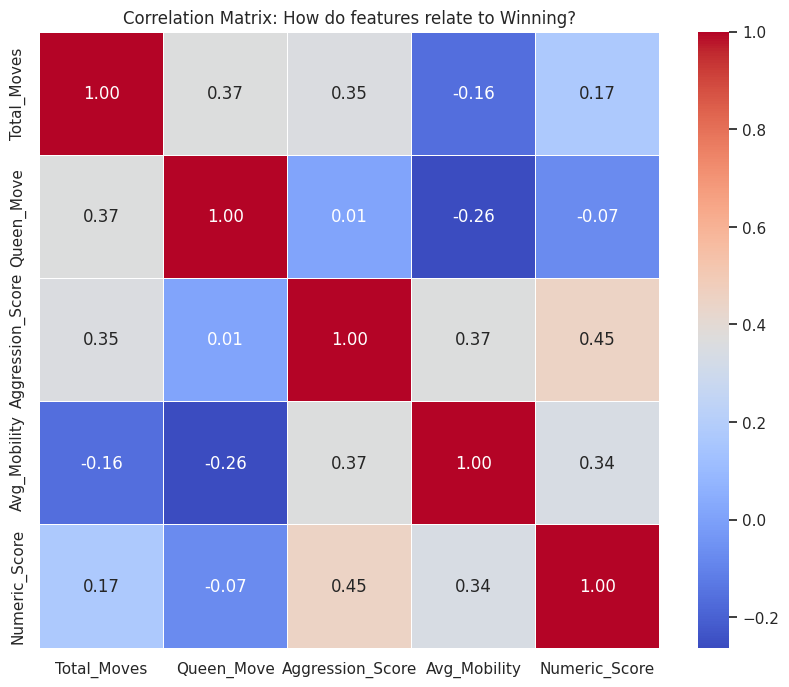

In [8]:
# Cell 3: Correlation Heatmap

# Select only the numerical columns we care about
numerical_cols = ['Total_Moves', 'Queen_Move', 'Aggression_Score', 'Avg_Mobility', 'Numeric_Score']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: How do features relate to Winning?")
plt.show()

/tmp/ipython-input-2774303606.py:8: FutureWarning: The provided callable <function mean at 0x7b0be4770220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(


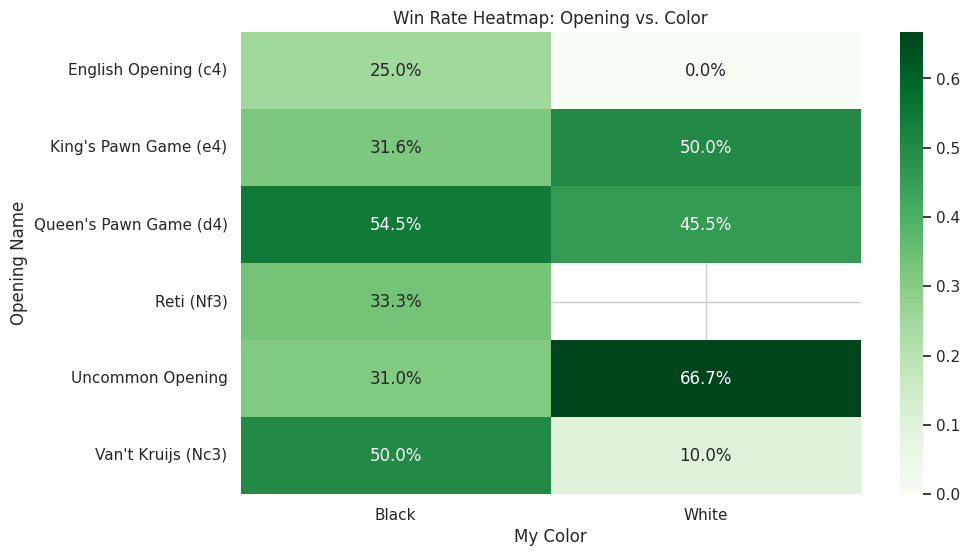

In [9]:
# Cell 4: Pivot Table & Heatmap (Openings)

# Filter for top 6 most common openings to keep the chart clean
top_openings = df['Opening'].value_counts().nlargest(6).index
subset_df = df[df['Opening'].isin(top_openings)]

# Create a Pivot Table: Rows=Opening, Cols=Color, Values=Win Rate
pivot_table = pd.pivot_table(
    subset_df,
    values='Numeric_Score',
    index='Opening',
    columns='My_Color',
    aggfunc=np.mean
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="Greens", fmt=".1%")
plt.title("Win Rate Heatmap: Opening vs. Color")
plt.ylabel("Opening Name")
plt.xlabel("My Color")
plt.show()

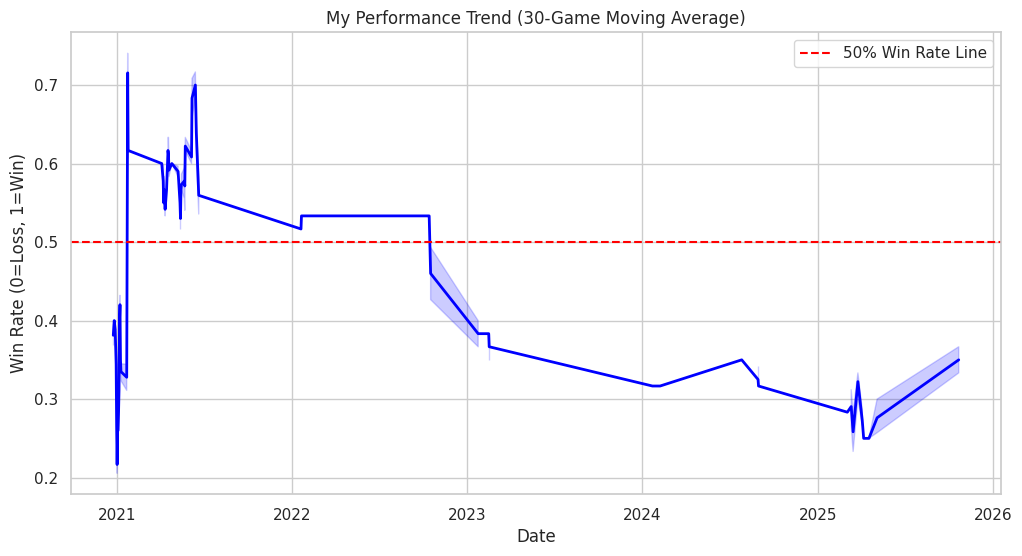

In [10]:
# Cell 5: Rolling Average (Learning Curve)

# Sort by date so time flows correctly
df = df.sort_values('Date')

# Calculate a 30-game Moving Average of my Score
# This smooths out lucky/unlucky streaks to show true skill
df['Rolling_Win_Rate'] = df['Numeric_Score'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Rolling_Win_Rate', data=df, color='blue', linewidth=2)
plt.title("My Performance Trend (30-Game Moving Average)")
plt.ylabel("Win Rate (0=Loss, 1=Win)")
plt.xlabel("Date")
plt.axhline(0.5, color='red', linestyle='--', label="50% Win Rate Line")
plt.legend()
plt.show()

/tmp/ipython-input-3086664267.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='My_Result', y='Aggression_Score', data=df,


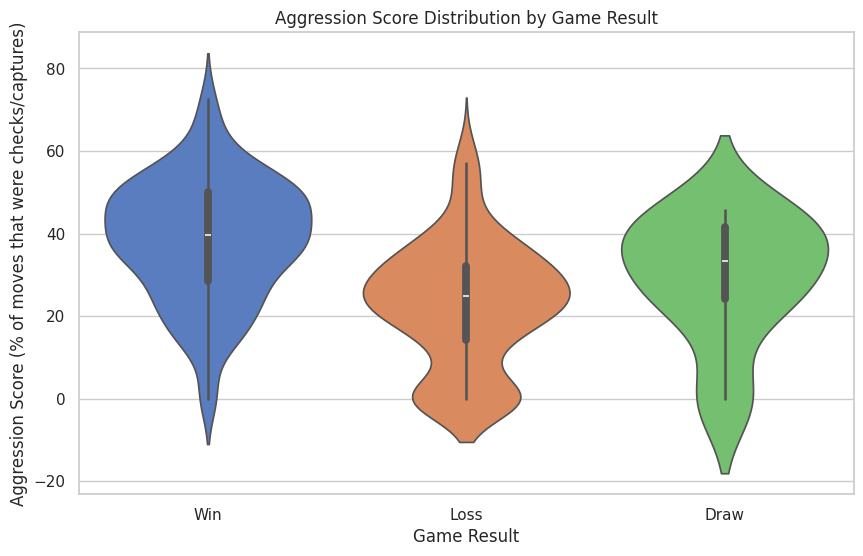

In [11]:
# Cell 6: Violin Plot - Aggression vs Result
# Research Question: Do I win more often when I play aggressively?

plt.figure(figsize=(10, 6))
sns.violinplot(x='My_Result', y='Aggression_Score', data=df,
               order=['Win', 'Loss', 'Draw'], palette="muted")
plt.title("Aggression Score Distribution by Game Result")
plt.xlabel("Game Result")
plt.ylabel("Aggression Score (% of moves that were checks/captures)")
plt.show()

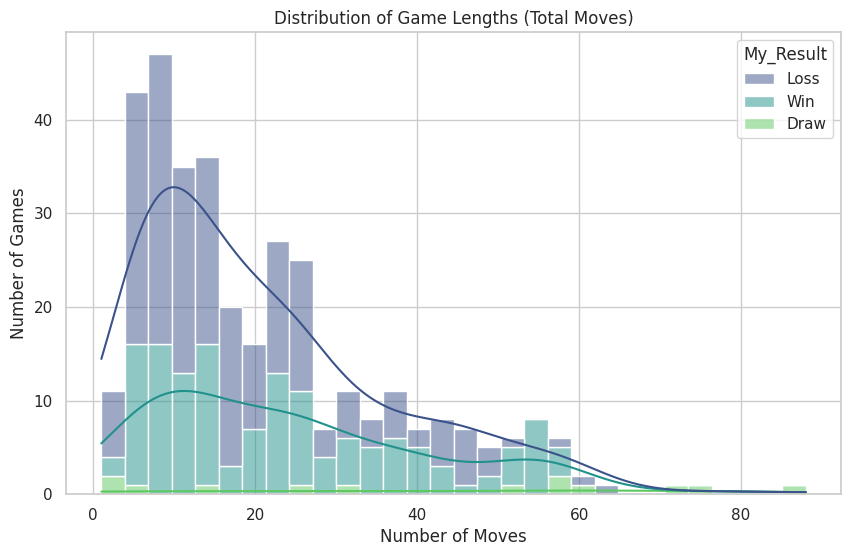

In [12]:
# Cell 7: Game Length Distribution
# Research Question: Do I tend to win short games or long games?

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Total_Moves', hue='My_Result',
             multiple="stack", bins=30, palette="viridis", kde=True)
plt.title("Distribution of Game Lengths (Total Moves)")
plt.xlabel("Number of Moves")
plt.ylabel("Number of Games")
plt.show()

/tmp/ipython-input-1720852648.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='My_Result', y='Queen_Move', data=queen_df,


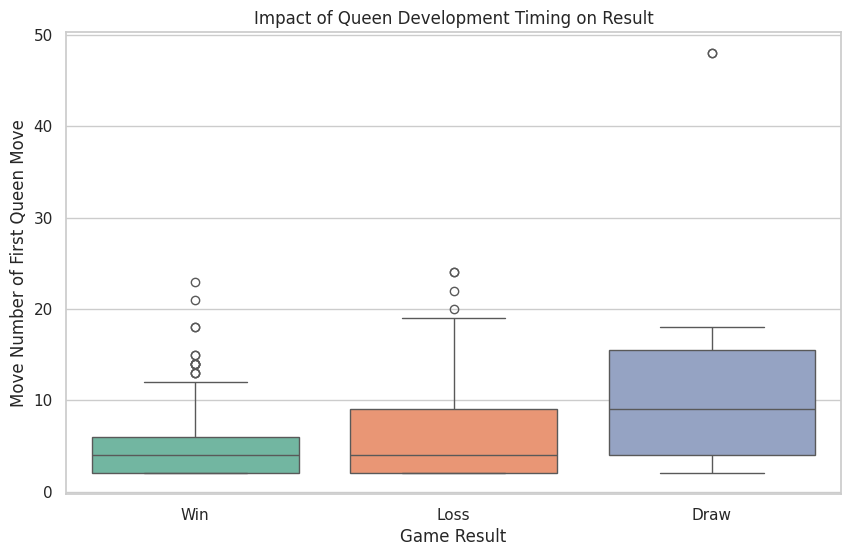

In [13]:
# Cell 8: Queen Development Timing
# Research Question: Does bringing the Queen out early hurt my chances?

plt.figure(figsize=(10, 6))
# Filter games where queen didn't move (NaN)
queen_df = df.dropna(subset=['Queen_Move'])

sns.boxplot(x='My_Result', y='Queen_Move', data=queen_df,
            order=['Win', 'Loss', 'Draw'], palette="Set2")
plt.title("Impact of Queen Development Timing on Result")
plt.xlabel("Game Result")
plt.ylabel("Move Number of First Queen Move")
plt.show()

/tmp/ipython-input-2922718208.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Game_Phase', y='Numeric_Score', data=phase_win_rates, palette="coolwarm")


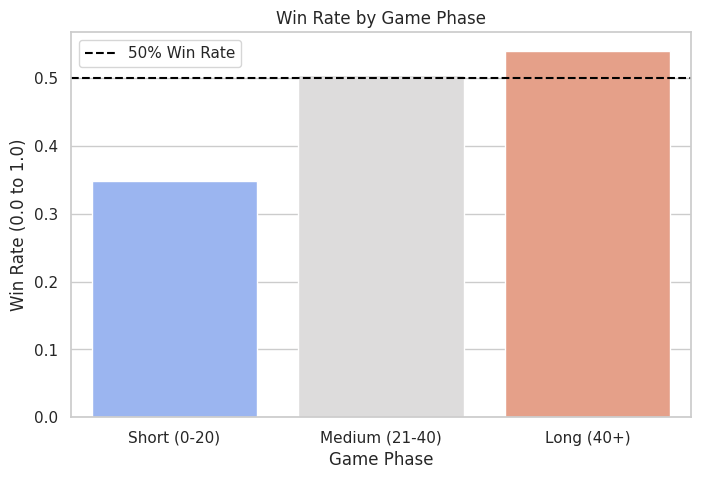

In [14]:
# Cell 9: Win Rate by Game Phase
# Research Question: Am I stronger in the opening or the endgame?

# Calculate average win rate (Numeric_Score) for each phase
phase_win_rates = df.groupby('Game_Phase', observed=False)['Numeric_Score'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Game_Phase', y='Numeric_Score', data=phase_win_rates, palette="coolwarm")
plt.title("Win Rate by Game Phase")
plt.xlabel("Game Phase")
plt.ylabel("Win Rate (0.0 to 1.0)")
plt.axhline(0.5, color='black', linestyle='--', label='50% Win Rate')
plt.legend()
plt.show()

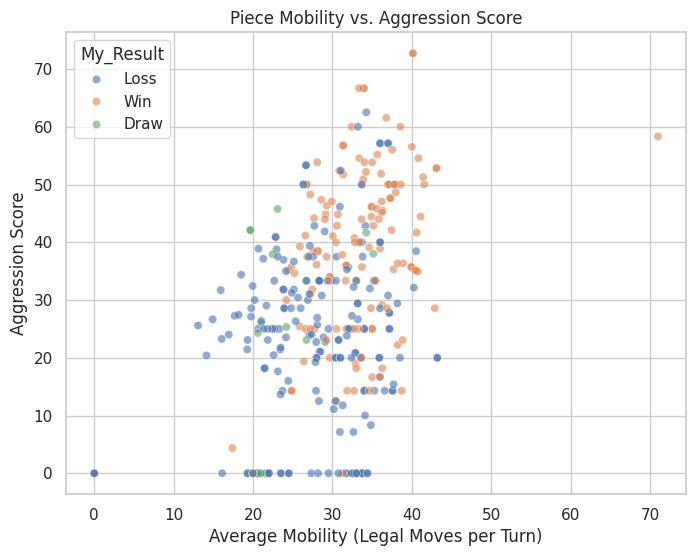

In [15]:
# Cell 10: Mobility vs Aggression Correlation
# Research Question: Does having more mobile pieces lead to more aggression?

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Avg_Mobility', y='Aggression_Score', hue='My_Result', alpha=0.6)
plt.title("Piece Mobility vs. Aggression Score")
plt.xlabel("Average Mobility (Legal Moves per Turn)")
plt.ylabel("Aggression Score")
plt.show()

# Hypothesis Testing

In [18]:
from scipy import stats
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [20]:
# Convert results to numeric scores
condition_list = [
    (df['My_Result'] == 'Win'),
    (df['My_Result'] == 'Draw'),
    (df['My_Result'] == 'Loss')
]
choice_list = [1.0, 0.5, 0.0]
df['Numeric_Score'] = np.select(condition_list, choice_list, default=np.nan)

print("=" * 70)
print("DATASET CREATED FOR HYPOTHESIS TESTING")
print("=" * 70)
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData summary:")
print(df[['My_Result', 'Numeric_Score', 'Total_Moves', 'Queen_Move']].describe())


DATASET CREATED FOR HYPOTHESIS TESTING

Dataset shape: (350, 11)

First few rows:
          Date My_Color My_Result                Opening  Total_Moves  \
285 2020-12-22    Black      Loss  King's Pawn Game (e4)           18   
284 2020-12-22    White       Win  King's Pawn Game (e4)            4   
286 2020-12-22    Black      Loss  King's Pawn Game (e4)           22   
287 2020-12-22    White      Loss  King's Pawn Game (e4)           20   
288 2020-12-22    Black      Loss  King's Pawn Game (e4)           60   

     Queen_Move  Aggression_Score  Avg_Mobility  Numeric_Score  \
285         NaN         17.647059     23.117647            0.0   
284         4.0         25.000000     27.750000            1.0   
286         8.0         14.285714     23.714286            0.0   
287         9.0         21.052632     28.368421            0.0   
288         3.0         27.118644     19.745763            0.0   

         Game_Phase  Rolling_Win_Rate  
285    Short (0-20)               NaN  
28

## Hypothesis 1 - Queen Development




*   H0: Early queen development has no effect on game outcome.
*   H1: Early queen development affects game outcome.



In [21]:
# 1. Drop games where the Queen never moved
queen_df = df.dropna(subset=['Queen_Move']).copy()

# 2. Define "Early" vs "Late" (e.g., move 10 as threshold, or use the median)
threshold = 10
early_queen = queen_df[queen_df['Queen_Move'] <= threshold]['Numeric_Score']
late_queen = queen_df[queen_df['Queen_Move'] > threshold]['Numeric_Score']

# 3. Perform T-Test
t_stat, p_val = stats.ttest_ind(early_queen, late_queen, equal_var=False)

print(f"--- Hypothesis 1: Queen Development (Threshold: Move {threshold}) ---")
print(f"Average Score (Early Queen): {early_queen.mean():.2f}")
print(f"Average Score (Late Queen):  {late_queen.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Reject H0. There is a statistically significant difference in performance.")
else:
    print("Result: Fail to reject H0. No significant difference found.")

--- Hypothesis 1: Queen Development (Threshold: Move 10) ---
Average Score (Early Queen): 0.46
Average Score (Late Queen):  0.38
T-statistic: 1.1282
P-value: 0.2623
Result: Fail to reject H0. No significant difference found.


## Hypothesis 2 - Performance by Color




*   H0: There is no performance difference when playing White or Black.
*   H1: Playing color affects performance.



In [22]:
# 1. Separate the data
white_scores = df[df['My_Color'] == 'White']['Numeric_Score']
black_scores = df[df['My_Color'] == 'Black']['Numeric_Score']

# 2. Perform T-Test
t_stat_color, p_val_color = stats.ttest_ind(white_scores, black_scores, equal_var=False)

print("--- Hypothesis 2: Performance by Color ---")
print(f"Average Score (White): {white_scores.mean():.2f}")
print(f"Average Score (Black): {black_scores.mean():.2f}")
print(f"T-statistic: {t_stat_color:.4f}")
print(f"P-value: {p_val_color:.4f}")

if p_val_color < 0.05:
    print("Result: Reject H0. Your performance differs significantly by color.")
else:
    print("Result: Fail to reject H0. No significant performance difference by color.")

--- Hypothesis 2: Performance by Color ---
Average Score (White): 0.47
Average Score (Black): 0.37
T-statistic: 1.8451
P-value: 0.0659
Result: Fail to reject H0. No significant performance difference by color.


## Hypothesis 3 - Game Length and Outcome



*   H0: Game length and outcome are independent.
*   H1: Game length and outcome are related.



In [23]:
# 1. Create a Contingency Table (Cross-tabulation)
contingency_table = pd.crosstab(df['Game_Phase'], df['My_Result'])

print("--- Contingency Table (Observed Counts) ---")
print(contingency_table)
print("\n")

# 2. Perform Chi-Square Test
chi2, p_val_chi, dof, expected = stats.chi2_contingency(contingency_table)

print("--- Hypothesis 3: Chi-Square Test of Independence ---")
print(f"Chi-square Statistic: {chi2:.4f}")
print(f"P-value: {p_val_chi:.4f}")

if p_val_chi < 0.05:
    print("Result: Reject H0. Game length and outcome are statistically related.")
else:
    print("Result: Fail to reject H0. Game length and outcome appear independent.")

--- Contingency Table (Observed Counts) ---
My_Result       Draw  Loss  Win
Game_Phase                     
Short (0-20)       4   131   69
Medium (21-40)     2    47   48
Long (40+)         7    19   23


--- Hypothesis 3: Chi-Square Test of Independence ---
Chi-square Statistic: 27.8672
P-value: 0.0000
Result: Reject H0. Game length and outcome are statistically related.


/tmp/ipython-input-4088983581.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Queen_Timing', y='Numeric_Score', data=df, ci=None, palette='viridis')
/tmp/ipython-input-4088983581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Queen_Timing', y='Numeric_Score', data=df, ci=None, palette='viridis')


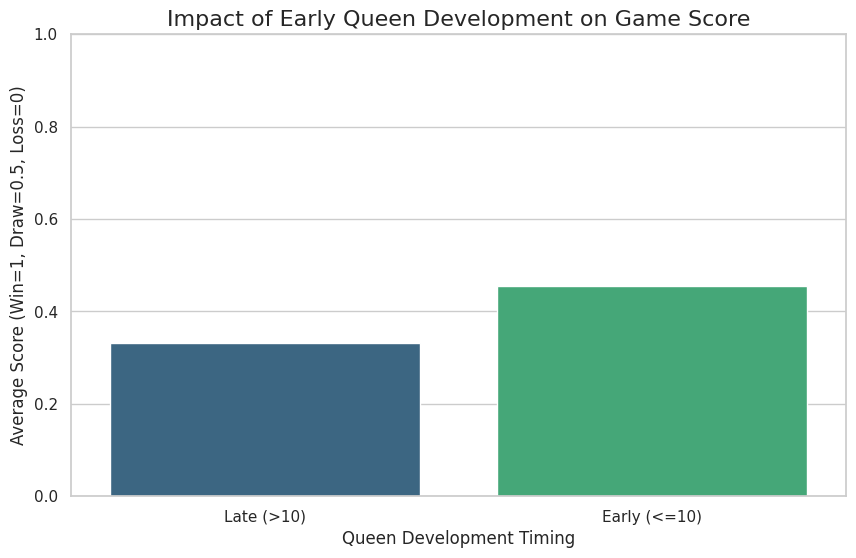

In [28]:
plt.figure(figsize=(10, 6))

# Create a temporary column for easier plotting
df['Queen_Timing'] = df['Queen_Move'].apply(lambda x: 'Early (<=10)' if x <= 10 else 'Late (>10)')

# Create the bar plot
sns.barplot(x='Queen_Timing', y='Numeric_Score', data=df, ci=None, palette='viridis')

plt.title('Impact of Early Queen Development on Game Score', fontsize=16)
plt.ylabel('Average Score (Win=1, Draw=0.5, Loss=0)', fontsize=12)
plt.xlabel('Queen Development Timing', fontsize=12)
plt.ylim(0, 1)  # Scores range from 0 to 1

plt.show()

/tmp/ipython-input-648366945.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='My_Color', y='Numeric_Score', data=df, ci=None,
/tmp/ipython-input-648366945.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='My_Color', y='Numeric_Score', data=df, ci=None,


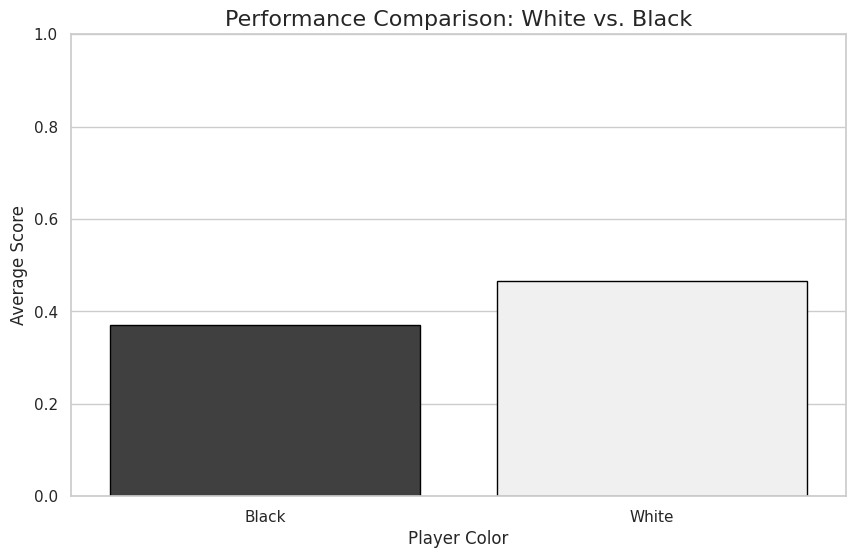

In [29]:
# Cell 10: Visualization - Performance by Color
plt.figure(figsize=(10, 6))

# Custom palette to match chess colors visually
color_palette = {"White": "#f0f0f0", "Black": "#404040"}

# Create the bar plot with black outlines for visibility
ax = sns.barplot(x='My_Color', y='Numeric_Score', data=df, ci=None,
                 palette=color_palette, edgecolor="black")

plt.title('Performance Comparison: White vs. Black', fontsize=16)
plt.ylabel('Average Score', fontsize=12)
plt.xlabel('Player Color', fontsize=12)
plt.ylim(0, 1)

plt.show()

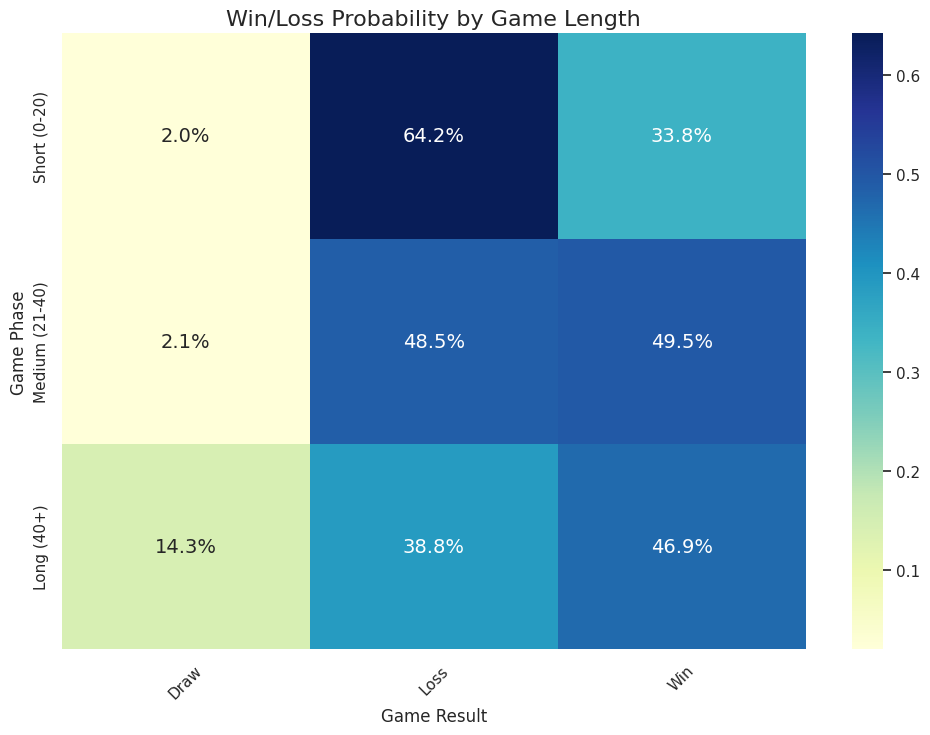

In [31]:
# Cell 11: Visualization - Game Phase vs Result Heatmap
plt.figure(figsize=(12, 8))

# Prepare the data: Normalized crosstab to show percentages
phase_result_data = pd.crosstab(df['Game_Phase'], df['My_Result'], normalize='index')


sns.heatmap(phase_result_data, annot=True, fmt='.1%', cmap="YlGnBu", cbar=True, annot_kws={"size": 14})

plt.title('Win/Loss Probability by Game Length', fontsize=16)
plt.ylabel('Game Phase', fontsize=12)
plt.xlabel('Game Result', fontsize=12)
plt.xticks(rotation=45)

plt.show()

# ML Part

## ML Data Preprocessing

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Prepare the Features (X)
# Make a copy to avoid warnings
ml_df = df.copy()

# Handle missing Queen moves (impute with a value indicating 'late/never', e.g., 100)
ml_df['Queen_Move'] = ml_df['Queen_Move'].fillna(100)

# Encode 'My_Color': White = 1, Black = 0
le_color = LabelEncoder()
ml_df['My_Color_Encoded'] = le_color.fit_transform(ml_df['My_Color'])

# Select Features
feature_cols = ['My_Color_Encoded', 'Queen_Move', 'Aggression_Score', 'Avg_Mobility']
X = ml_df[feature_cols]

# 2. Prepare the Target (y) - We want to predict 'My_Result' (Win/Loss/Draw)
# Encode Result: Loss=0, Draw=1, Win=2 (arbitrary order, but mapped to numbers)
le_result = LabelEncoder()
y = le_result.fit_transform(ml_df['My_Result'])

# 3. Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully prepared for Machine Learning.")
print(f"Training Data Size: {X_train.shape[0]} games")
print(f"Testing Data Size: {X_test.shape[0]} games")

Data successfully prepared for Machine Learning.
Training Data Size: 280 games
Testing Data Size: 70 games


## K-Nearest Neighbors (KNN)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. Scale the features (Important for KNN!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Initialize and Train KNN
# n_neighbors=5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# 3. Predict and Evaluate
y_pred_knn = knn_model.predict(X_test_scaled)

print("--- KNN Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
print("\nClassification Report:\n")
# We use le_result.classes_ to convert numbers 0,1,2 back to 'Draw', 'Loss', 'Win'
print(classification_report(y_test, y_pred_knn, target_names=le_result.classes_))

--- KNN Results ---
Accuracy: 0.69

Classification Report:

              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00         4
        Loss       0.67      0.78      0.72        36
         Win       0.71      0.67      0.69        30

    accuracy                           0.69        70
   macro avg       0.46      0.48      0.47        70
weighted avg       0.65      0.69      0.66        70



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

# 1. Initialize and Train
# max_depth=5 prevents the tree from becoming too complex and overfitting
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# 2. Predict and Evaluate
y_pred_dt = dt_model.predict(X_test)

print("--- Decision Tree Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt, target_names=le_result.classes_))

--- Decision Tree Results ---
Accuracy: 0.71

Classification Report:

              precision    recall  f1-score   support

        Draw       0.33      0.25      0.29         4
        Loss       0.69      0.81      0.74        36
         Win       0.80      0.67      0.73        30

    accuracy                           0.71        70
   macro avg       0.61      0.57      0.59        70
weighted avg       0.72      0.71      0.71        70



## Random Forest & Feature Importance

--- Random Forest Results ---
Accuracy: 0.76

Classification Report:

              precision    recall  f1-score   support

        Draw       1.00      0.25      0.40         4
        Loss       0.74      0.81      0.77        36
         Win       0.77      0.77      0.77        30

    accuracy                           0.76        70
   macro avg       0.84      0.61      0.65        70
weighted avg       0.77      0.76      0.75        70



/tmp/ipython-input-3915035455.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


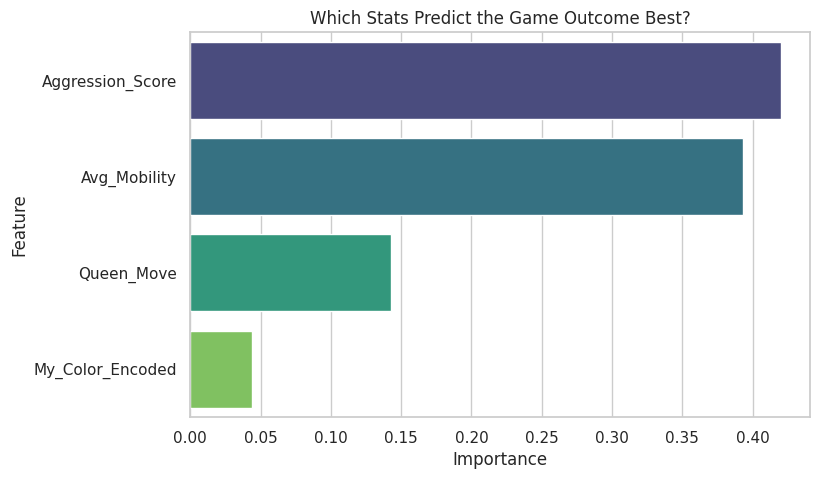

In [37]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns

# 1. Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 2. Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)

print("--- Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=le_result.classes_))

# 3. Visualization: Feature Importance
# Which factors mattered most for the prediction?
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Which Stats Predict the Game Outcome Best?')
plt.show()

## Visuals

### Confusion Matrices for All Models

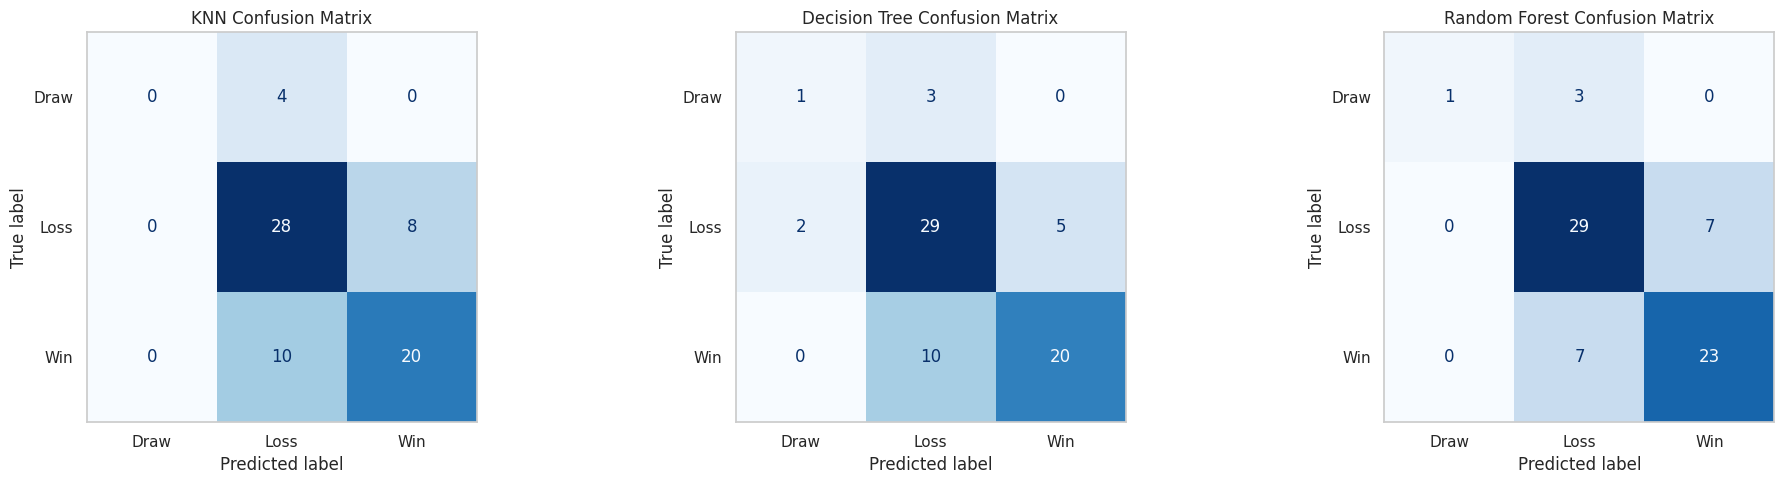

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# List of models and their predictions
models = [('KNN', y_pred_knn),
          ('Decision Tree', y_pred_dt),
          ('Random Forest', y_pred_rf)]

class_names = le_result.classes_  # ['Draw', 'Loss', 'Win']

for i, (name, pred) in enumerate(models):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].grid(False) # Turn off grid lines for cleaner text

plt.tight_layout()
plt.show()

### Decision Tree Logic

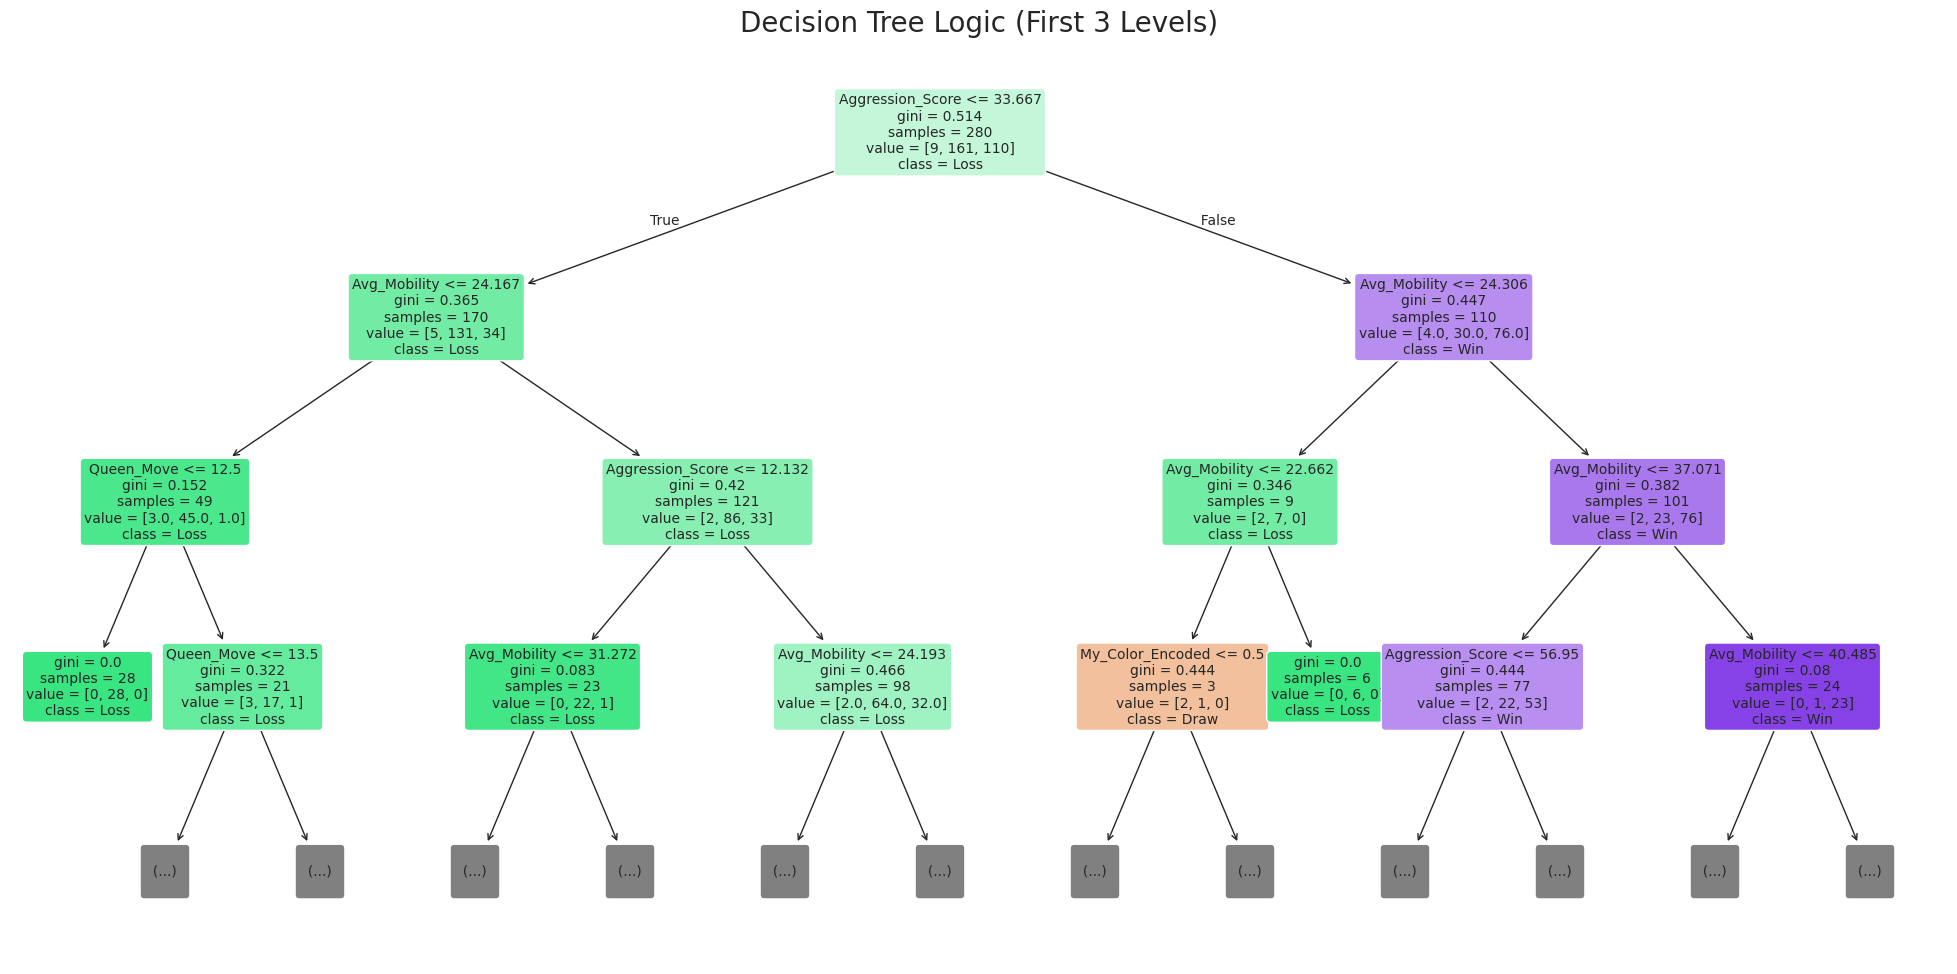

In [41]:
plt.figure(figsize=(25, 12))

tree.plot_tree(dt_model,
               feature_names=feature_cols,
               class_names=list(le_result.classes_),
               filled=True,
               rounded=True,
               fontsize=10,
               max_depth=3) # Limit depth for visibility

plt.title("Decision Tree Logic (First 3 Levels)", fontsize=20)
plt.show()

### Model Accuracy Comparison

/tmp/ipython-input-285395087.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=model_names, y=accuracies, palette='magma', edgecolor='black')


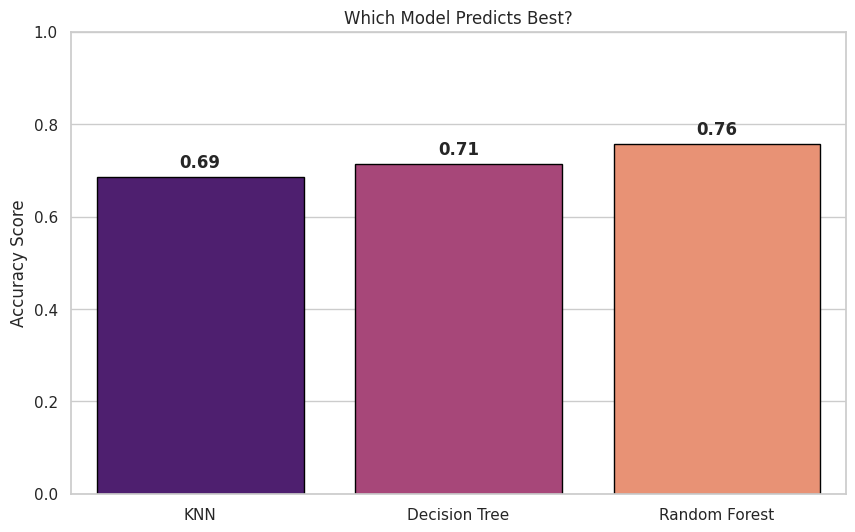

In [42]:
model_names = ['KNN', 'Decision Tree', 'Random Forest']
accuracies = [accuracy_score(y_test, y_pred_knn),
              accuracy_score(y_test, y_pred_dt),
              accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=model_names, y=accuracies, palette='magma', edgecolor='black')

plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('Which Model Predicts Best?')

# Add text labels on top of bars
for bar, acc in zip(bars.patches, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{acc:.2f}',
             ha='center', fontsize=12, fontweight='bold')

plt.show()